In [29]:
import numpy as np
import pandas as pd

from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt

import os
import pyarrow.parquet as pq
from sklearn.preprocessing import MinMaxScaler
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


data_dir = '../data'

In [30]:
df_train_curves_info = pd.read_csv(os.path.join(data_dir, 'train_curves_info_200_words.csv'))
df_train_curves_info = df_train_curves_info.drop(columns=[df_train_curves_info.columns[0], 'keyboard_id'])

df_keyboards = pd.read_csv(os.path.join(data_dir, 'keyboards_full.csv'))
df_keys = pd.read_csv(os.path.join(data_dir, 'keys_full.csv'))

In [31]:
alphabet = list(df_keys[df_keys['keyboard_id'] == 0]['label'].values)
alphabet.insert(0, '_')
idx2char = {idx: char for idx, char in enumerate(alphabet)}
char2idx = {char: idx for idx, char in enumerate(alphabet)}
alphabet

['_',
 'й',
 'ц',
 'у',
 'к',
 'е',
 'н',
 'г',
 'ш',
 'щ',
 'з',
 'х',
 'ф',
 'ы',
 'в',
 'а',
 'п',
 'р',
 'о',
 'л',
 'д',
 'ж',
 'э',
 'shift',
 'я',
 'ч',
 'с',
 'м',
 'и',
 'т',
 'ь',
 'б',
 'ю',
 'backspace',
 'toNumberState',
 'globe',
 ',',
 'space',
 '.',
 'enter']

In [32]:
df_train_curves = pd.read_csv(os.path.join(data_dir, 'train_curves_01.csv'))
df_train_curves = df_train_curves.drop(columns=[df_train_curves.columns[0], *list(df_train_curves.filter(regex='key_').columns)])
df_train_curves

,curve_id,x,y,dt,vx,vy,ax,ay
0,3,0.317460,0.416667,0.000000,0.118768,0.027734,0.004831,0.004644
1,3,0.317460,0.424797,0.067298,0.118768,0.115221,0.004831,0.010752
2,3,0.322129,0.469512,0.017876,0.261575,1.839241,0.032609,0.457798
3,3,0.329599,0.524390,0.017876,0.347259,2.250947,0.021498,0.112860
4,3,0.335201,0.561992,0.018927,0.280616,1.466418,-0.007412,-0.190111
...,...,...,...,...,...,...,...,...
322791,89140,0.738562,0.611789,0.017876,2.032384,0.851146,-0.005972,0.047329
322792,89140,0.784314,0.631098,0.013670,1.948897,1.050665,-0.016405,0.073224
322793,89140,0.824463,0.660569,0.017876,1.346910,1.221682,-0.112265,0.049595
322794,89140,0.861811,0.692073,0.017876,1.261225,1.304023,-0.011836,0.026287


In [182]:
#counts = df_train_curves.groupby("curve_id").size().sort_values()
#short_curve_ids = list(counts[:300].index)

#df_train_curves = df_train_curves[df_train_curves['curve_id'].isin(short_curve_ids)]
#df_train_curves_info = df_train_curves_info[df_train_curves_info['curve_id'].isin(short_curve_ids)]

In [33]:
df_train_curves

,curve_id,x,y,dt,vx,vy,ax,ay
0,3,0.317460,0.416667,0.000000,0.118768,0.027734,0.004831,0.004644
1,3,0.317460,0.424797,0.067298,0.118768,0.115221,0.004831,0.010752
2,3,0.322129,0.469512,0.017876,0.261575,1.839241,0.032609,0.457798
3,3,0.329599,0.524390,0.017876,0.347259,2.250947,0.021498,0.112860
4,3,0.335201,0.561992,0.018927,0.280616,1.466418,-0.007412,-0.190111
...,...,...,...,...,...,...,...,...
322791,89140,0.738562,0.611789,0.017876,2.032384,0.851146,-0.005972,0.047329
322792,89140,0.784314,0.631098,0.013670,1.948897,1.050665,-0.016405,0.073224
322793,89140,0.824463,0.660569,0.017876,1.346910,1.221682,-0.112265,0.049595
322794,89140,0.861811,0.692073,0.017876,1.261225,1.304023,-0.011836,0.026287


In [34]:
df_train_curves_info

,curve_id,word_index
0,3,150496
1,4,150496
2,5,228427
3,11,113747
4,14,435383
...,...,...
9995,88365,134611
9996,88445,162841
9997,88729,134611
9998,88936,162841


In [35]:
unique_vals = df_train_curves_info['curve_id'].unique()
sampled = np.random.choice(
    unique_vals,
    size=int(0.2 * len(unique_vals)),
    replace=False
)
df_test_curves = df_train_curves[df_train_curves['curve_id'].isin(sampled)]
df_train_curves = df_train_curves[~df_train_curves['curve_id'].isin(sampled)]

In [36]:
with open(os.path.join(data_dir, 'voc.txt')) as f:
    df_voc = pd.DataFrame()
    words = f.readlines()
    df_voc['word'] = words
curveid2wordind = df_train_curves_info.set_index('curve_id')
curveid2word = curveid2wordind['word_index'].map(df_voc.to_dict()['word'])
words = list(curveid2word.to_dict().values())

In [37]:
class CurvesDataset(Dataset):
    def __init__(self, curves_df, curve2word, max_length=300):
        self.max_length = max_length
        self.curves_df = curves_df
        self.curve_ids = self.curves_df['curve_id'].unique().tolist()
        self.curve2word = curve2word

    def __len__(self):
        return len(self.curve_ids)

    def __getitem__(self, idx):
        curve_id = self.curve_ids[idx]
        
        # (x, y, t) → scale
        seq_df = self.curves_df[self.curves_df['curve_id'] == curve_id]
        seq_df = seq_df.drop(columns=['curve_id']).values.astype(np.float32)
        seq = torch.tensor(seq_df, dtype=torch.float32)

        # label
        word = self.curve2word[curve_id]
        label = [char2idx[c] for c in word.strip()]

        return seq, label, seq.size(0)   # (sequence, label, sequence_length)
    
def pad_collate(batch, max_length=300):
    sequences, labels, lengths = zip(*batch)

    padded = []
    seqlens = []
    for seq in sequences:
        seqlens.append(len(seq))
        if seq.size(0) < max_length:
            pad = F.pad(seq, (0, 0, 0, max_length - seq.size(0)))
        else:
            pad = seq[:max_length]
        padded.append(pad)

    padded = torch.stack(padded)
    seqlens = torch.tensor(seqlens, dtype=torch.int)
    labelslen = torch.tensor([len(label) for label in labels], dtype=torch.int)
    labelsflat = []
    for label in labels:
        labelsflat.extend(label)
    labels = torch.tensor(labelsflat, dtype=torch.int)

    return padded, seqlens, labels, labelslen


In [38]:
ds = CurvesDataset(
    curves_df=df_train_curves,
    max_length=300,
    curve2word=curveid2word
)

In [39]:
device = torch.device(
    'cuda' if torch.cuda.is_available() else
    'mps' if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available() else
    'cpu'
)

print(f"Используемое устройство: {device}")

Используемое устройство: cuda


In [42]:
input_size = 7        # размер точки: x,y,t
hidden_size = 512    # размер скрытого состояния LSTM
alphabet_size = 40     # количество символов (A-Z + спецсимволы)
num_epochs = 200
batch_size=500

In [43]:
train_loader = DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4 if torch.cuda.is_available() else 0,
    pin_memory=torch.cuda.is_available(),
    collate_fn=lambda batch: pad_collate(batch, max_length=300)
)

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim


class SwipeLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, alphabet_size)

    def forward(self, x):
        outputs, (h_n, c_n) = self.lstm(x)
        logits = self.fc(outputs)
        #probs = torch.softmax(logits, dim=-1)
        return logits

model = SwipeLSTM().to(device)

ctc_loss = nn.CTCLoss(blank=0)  # blank=0
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [45]:
#feature_cols = [
#    'x', 'y', 'dt',
#    'vx', 'vy',
#    'ax', 'ay',
#] # + [c for c in df_train_curves.columns if c.startswith('key_')]
#sequences = []
#lengths = []

#for curve_id, g in df_train_curves.groupby('curve_id'):
#    #g = g.sort_values('t')  # важно!
#    x = g[feature_cols].values.astype(np.float32)
#    sequences.append(torch.tensor(x))
#    lengths.append(len(x))
    
#from torch.nn.utils.rnn import pad_sequence

##X = pad_sequence(sequences, batch_first=True)
#X = pad_sequence(sequences)

In [46]:
#X.shape

In [47]:
def ctc_greedy_decode(log_probs, blank=0):

    T, B, C = log_probs.shape
    preds = log_probs.argmax(dim=-1)  # (T, B)

    results = []

    for b in range(B):
        seq = []
        prev = blank

        for t in range(T):
            cur = preds[t, b].item()
            if cur != blank and cur != prev:
                seq.append(cur)
            #seq.append(cur)
            prev = cur
        results.append(seq)
    return results

def split_targets(targets, target_lengths):
    res = []
    idx = 0
    for l in target_lengths:
        res.append(targets[idx:idx+l].tolist())
        idx += l
    return res
def sequence_accuracy(preds, targets):
    correct = 0
    for p, t in zip(preds, targets):
        if p == t:
            correct += 1
    return correct / len(targets)

def decode_sequence(seq, blank=0):
    chars = []
    
    for idx in seq:
        chars.append(idx2char[idx])


    return "".join(chars)

import editdistance

def cer(preds, targets):
    total_dist = 0
    total_chars = 0

    for p, t in zip(preds, targets):
        dist = editdistance.eval(p, t)
        total_dist += dist
        total_chars += len(t)

    if total_chars == 0:
        return 0.0

    return total_dist / total_chars

def build_trajectories(df):
    trajectories = []
    xs = []
    ys = []

    for curve_id, g in df.groupby("curve_id"):
        X = g[["x", "y", "dt", "vx", "vy", "ax", "ay"]].values.astype("float32")
        word = curveid2word[curve_id]
        y = [char2idx[c] for c in word.strip()]
        trajectories.append((X, y))

    return trajectories

def predict_sequence(model, X):
    model.eval()
    with torch.no_grad():
        X = torch.tensor(X).unsqueeze(1).to(device)
        logits = model(X)
        log_probs = torch.log_softmax(logits, dim=-1)
        pred_ids = ctc_greedy_decode(log_probs)
        return pred_ids
    
def evaluate(model, df_test):
    trajectories = build_trajectories(df_test)

    total = 0
    correct = 0
    cer_sum = 0.0
    
    y_true = [y_true for _, y_true in trajectories]
    y_pred = [predict_sequence(model, X)[0] for X, _ in trajectories]
    cer_val = cer(y_pred, y_true)
    acc = sequence_accuracy(y_pred, y_true)

    return acc, cer_val

In [202]:
#input_lengths = torch.tensor(lengths, dtype=torch.int)
#targets = torch.tensor(targets, dtype=torch.int)
#target_lengths = torch.tensor(target_lengths, dtype=torch.int)
#print(len(input_lengths))
#print(len(target_lengths))

bak

CER = []
losses = []
blank_ratios = []
epochs = [i for i in range(num_epochs)]
for epoch in tqdm(range(num_epochs)):
    model.train()
    optimizer.zero_grad()

    # forward
    logits = model(X)                      # raw logits
    print("logits shape " + str(logits.shape))
    log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
    print("log probs shape " + str(log_probs.shape))
    # вычисляем CTC loss
    loss = ctc_loss(log_probs, targets, input_lengths, target_lengths)

    # backward
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        preds = ctc_greedy_decode(log_probs)
        true = split_targets(targets, target_lengths)
        #print(true)
        cer_value = cer(preds, true)
        #acc = sequence_accuracy(preds, true)
        print([decode_sequence(resseq) for resseq in preds])
        
    preds = log_probs.argmax(dim=-1)
    blank_ratio = (preds == 0).float().mean()
    #print("blank ratio:", blank_ratio.item())
    #print("max logit per frame:", log_probs.max(dim=-1)[0].mean())
    #print("blank probability mean:", log_probs[:, :, 0].exp().mean())
    #print("blank probability mean:", log_probs[:, :, 0].exp().mean())
    CER.append(cer_value)
    losses.append(loss.item())
    blank_ratios.append(blank_ratio)
    #print(
    #    f"Epoch {epoch+1} | "
    #    f"Loss: {loss.item():.4f} | "
    #    f"CER: {cer_value:.4f}"
        #f"Acc: {acc:.4f}"
    #)

In [48]:
import warnings
warnings.filterwarnings('ignore')

In [49]:
CER = []
losses = []
accuracies = []
accuracies_test = []
CER_test = []
epochs = []
cnt = 1

for epoch in range(num_epochs):
    model.train()

    pbar = train_loader
    preds = []
    true = []
    epoch_loss = 0
    num_samples = 0
    epochs.append(cnt)
    cnt += 1

    for inputs, input_lengths, targets, target_lengths, in tqdm(pbar):
        inputs, input_lengths, targets, target_lengths = inputs.to(device), input_lengths.to(device), targets.to(device), target_lengths.to(device)
    
        optimizer.zero_grad()
        inputs = inputs.permute(1, 0, 2)
        #print(inputs.shape)
        #print(targets[:30])
        #print(target_lengths[:30])
        
        logits = model(inputs)                      # raw logits
        log_probs = torch.nn.functional.log_softmax(logits, dim=-1)
        
        loss = ctc_loss(log_probs, targets, input_lengths, target_lengths)
        epoch_loss += loss.item() * batch_size
        num_samples += batch_size

        # backward
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            preds.extend(ctc_greedy_decode(log_probs))
            true.extend(split_targets(targets, target_lengths))
            #print([decode_sequence(resseq) for resseq in preds])

    cer_value = cer(preds, true)
    acc = sequence_accuracy(preds, true)
    epoch_loss /= num_samples

    acc_test, cer_value_test = evaluate(model, df_test_curves)
    CER.append(cer_value)
    losses.append(epoch_loss)
    accuracies.append(acc)
    CER_test.append(cer_value_test)
    accuracies_test.append(acc_test)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:14<00:00,  4.64s/it]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:13<00:00,  4.62s/it]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:14<00:00,  4.63s/it]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:14<00:00,  4.65s/it]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:14<00:00,  4.65s/it]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:14<00:00,  4.64s/it]


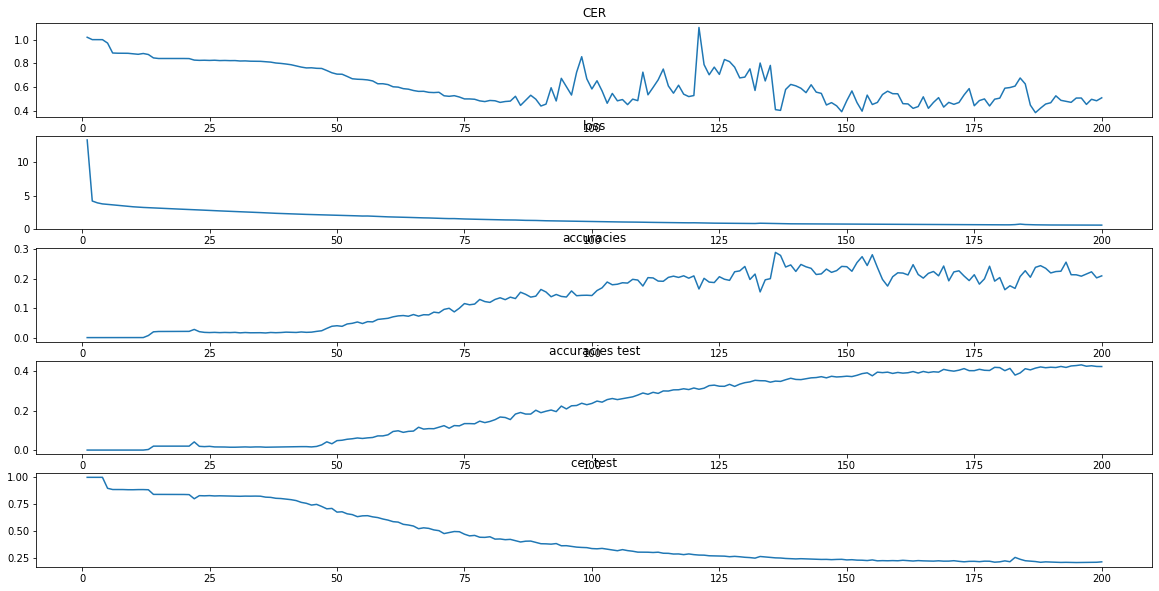

In [50]:
fig, (axcer, axloss, axac, axactest, axcertest) = plt.subplots(5, 1, figsize=(20,10))
axcer.plot(epochs, CER, label="CER")
axcer.set_title('CER')
axloss.plot(epochs, losses, label="losses")
axloss.set_title("loss")
axac.plot(epochs, accuracies, label="accuracies")
axac.set_title("accuracies")
axactest.plot(epochs, accuracies_test, label="accuracies test")
axactest.set_title("accuracies test")
axcertest.plot(epochs, CER_test, label="cer test")
axcertest.set_title("cer test")
plt.show()

In [51]:
torch.save(model.state_dict(), './model2.pt')

Text(0.5, 1.0, 'accuracies')

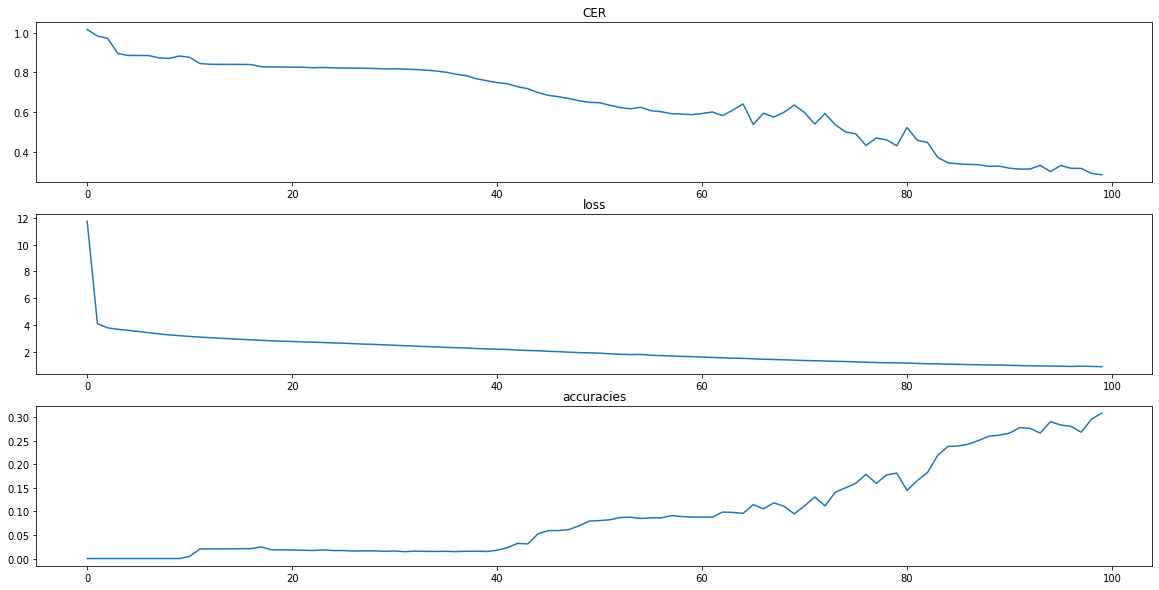

In [220]:
print(CER[-10:])
print(losses[-10:])
print(accuracies[-10:])

[0.3156285714285714, 0.3112, 0.3114857142857143, 0.3299142857142857, 0.29874285714285714, 0.3296, 0.3154, 0.3144857142857143, 0.28922857142857145, 0.2822857142857143]
[0.9727153271436692, 0.9556894630193711, 0.9368412494659424, 0.925816360116005, 0.9218909829854965, 0.9059628844261169, 0.8909610420465469, 0.9084096103906631, 0.8921144008636475, 0.8728780567646026]
[0.2665, 0.2782, 0.2766, 0.2665, 0.2909, 0.2837, 0.2808, 0.2683, 0.296, 0.3088]


In [68]:
acc_test, cer_value_test = evaluate(model, df_test_curves)
acc_test, cer_value_test

[[4, 15, 4], [6, 5], [29, 5, 31, 5], [29, 13], [31, 13], [29, 15, 27], [11, 18, 17, 18, 8, 18], [5, 26, 29, 30], [27, 6, 5], [6, 15], [6, 18], [25, 29, 18], [5, 26, 29, 30], [6, 5, 29], [29, 5, 31, 24], [29, 15, 27], [29, 15, 4], [3, 21, 5], [26, 5, 1, 25, 15, 26], [16, 17, 28, 14, 5, 29], [20, 15], [7, 20, 5], [29, 13], [25, 29, 18], [16, 18], [16, 17, 28, 14, 5, 29], [25, 29, 18], [29, 13], [25, 5], [20, 15], [6, 3], [18, 6], [18, 4], [6, 15], [4, 15, 4], [11, 18, 17, 18, 8, 18], [5, 26, 19, 28], [4, 15, 4], [28, 19, 28], [27, 6, 5], [4, 18, 7, 20, 15], [6, 3], [28, 19, 28], [6, 15, 20, 18], [5, 26, 19, 28], [11, 18, 17, 18, 8, 18], [10, 15], [16, 17, 18, 26, 29, 18], [29, 5, 31, 5], [29, 13], [14, 26, 5], [22, 29, 18], [27, 5, 6, 24], [6, 5], [6, 3], [6, 5], [26, 16, 15, 26, 28, 31, 18], [6, 3], [25, 29, 18], [27, 5, 6, 24], [18, 6], [29, 15, 4], [16, 17, 28, 14, 5, 29], [29, 13], [6, 15], [6, 5], [4, 15, 4], [22, 29, 18], [25, 29, 18], [4, 18, 7, 20, 15], [22, 29, 18], [18, 6], [16

(0.327, 0.25669897377423034)

In [94]:
#del log_probs, loss, outputs
import gc
gc.collect()
torch.cuda.empty_cache()

In [253]:
ind = 3425
X = torch.tensor(ds.__getitem__(ind)[0])
print(decode_sequence(ds.__getitem__(ind)[1]))
# CTC ждёт (T, batch, input_size)
X = X.unsqueeze(1)
X = X.to(device)

все


In [254]:
model.eval()
with torch.no_grad():
    logits = model(X)                      # (T, 1, vocab)
    log_probs = torch.log_softmax(logits, dim=-1)

In [256]:
pred_ids = ctc_greedy_decode(log_probs)
pred_word = ''.join(idx2char[i] for i in pred_ids[0])

print(pred_word)
#print(df_train_curves_info[df_train_curves_info['curve_id']])

все


In [95]:
for inputs, input_lengths, targets, target_lengths, in tqdm(pbar):
    print([decode_sequence(seq) for seq in split_targets(targets, target_lengths)])

  2%|████▏                                                                                                                                                                | 25/1000 [00:00<00:07, 133.56it/s]

['есть', 'бы', 'хочу', 'еще', 'он', 'мы', 'хочу', 'только', 'ты', 'где']
['будет', 'или', 'до', 'что', 'где', 'надо', 'же', 'бы', 'мы', 'есть']
['да', 'завтра', 'хочу', 'так', 'где', 'будет', 'хорошо', 'то', 'что', 'по']
['есть', 'тебя', 'есть', 'до', 'да', 'же', 'надо', 'уже', 'сейчас', 'она']
['будет', 'да', 'просто', 'привет', 'так', 'хочу', 'на', 'что', 'тебя', 'что']
['ну', 'тоже', 'надо', 'она', 'хочу', 'сейчас', 'надо', 'за', 'меня', 'на']
['будет', 'что', 'есть', 'мы', 'привет', 'где', 'до', 'как', 'там', 'будет']
['меня', 'ну', 'не', 'еще', 'когда', 'нет', 'когда', 'сегодня', 'на', 'тоже']
['нет', 'мне', 'тебя', 'привет', 'уже', 'уже', 'то', 'привет', 'привет', 'привет']
['можно', 'сегодня', 'по', 'она', 'тебя', 'где', 'есть', 'что', 'хорошо', 'сегодня']
['завтра', 'на', 'все', 'уже', 'тебя', 'сегодня', 'же', 'ну', 'да', 'тебя']
['знаю', 'мне', 'же', 'это', 'привет', 'хочу', 'нет', 'знаю', 'или', 'сейчас']
['это', 'она', 'надо', 'завтра', 'по', 'ну', 'вот', 'где', 'мне', 'ты']

  7%|████████████                                                                                                                                                         | 73/1000 [00:00<00:04, 197.11it/s]

['надо', 'он', 'не', 'тебя', 'когда', 'меня', 'вот', 'не', 'ты', 'так']
['сегодня', 'все', 'она', 'это', 'сейчас', 'ну', 'все', 'еще', 'меня', 'тебе']
['если', 'да', 'надо', 'за', 'мы', 'она', 'сейчас', 'тебя', 'мы', 'где']
['если', 'ок', 'тоже', 'хочу', 'надо', 'уже', 'мне', 'до', 'можно', 'когда']
['сейчас', 'бы', 'хорошо', 'сегодня', 'там', 'на', 'по', 'сейчас', 'не', 'хочу']
['это', 'будет', 'только', 'там', 'когда', 'все', 'по', 'за', 'просто', 'когда']
['она', 'уже', 'спасибо', 'уже', 'же', 'то', 'он', 'когда', 'ок', 'еще']
['тебе', 'как', 'хочу', 'уже', 'где', 'будет', 'он', 'че', 'что', 'не']
['же', 'просто', 'до', 'же', 'где', 'еще', 'просто', 'есть', 'он', 'за']
['или', 'надо', 'еще', 'или', 'нет', 'он', 'где', 'просто', 'вот', 'ну']
['когда', 'хочу', 'тебе', 'мне', 'то', 'мы', 'там', 'меня', 'по', 'там']
['или', 'меня', 'надо', 'да', 'это', 'будет', 'так', 'она', 'он', 'мне']
['спасибо', 'че', 'надо', 'завтра', 'когда', 'просто', 'знаю', 'да', 'ну', 'за']
['это', 'но', 'он',

 12%|███████████████████▊                                                                                                                                                | 121/1000 [00:00<00:04, 217.73it/s]

['то', 'не', 'там', 'спасибо', 'как', 'она', 'когда', 'так', 'он', 'меня']
['вот', 'он', 'за', 'то', 'что', 'хорошо', 'до', 'до', 'он', 'как']
['надо', 'как', 'же', 'бы', 'хочу', 'не', 'только', 'тоже', 'там', 'на']
['меня', 'будет', 'просто', 'если', 'мы', 'до', 'не', 'что', 'все', 'мы']
['привет', 'не', 'завтра', 'спасибо', 'на', 'тоже', 'то', 'привет', 'просто', 'завтра']
['ну', 'вот', 'знаю', 'где', 'как', 'она', 'сегодня', 'будет', 'тебя', 'мне']
['когда', 'там', 'привет', 'же', 'мы', 'тоже', 'не', 'это', 'есть', 'тебя']
['тебе', 'то', 'ну', 'еще', 'за', 'что', 'только', 'где', 'вот', 'можно']
['не', 'все', 'он', 'мы', 'то', 'тоже', 'сейчас', 'тоже', 'что', 'где']
['где', 'уже', 'хорошо', 'там', 'или', 'привет', 'еще', 'когда', 'это', 'она']
['мне', 'просто', 'все', 'спасибо', 'сегодня', 'знаю', 'еще', 'по', 'мне', 'будет']
['или', 'хочу', 'еще', 'надо', 'можно', 'завтра', 'че', 'сейчас', 'она', 'надо']
['так', 'он', 'завтра', 'за', 'мне', 'не', 'по', 'это', 'он', 'то']
['все', 'с

 17%|███████████████████████████▌                                                                                                                                        | 168/1000 [00:00<00:03, 224.54it/s]

['уже', 'по', 'хорошо', 'что', 'не', 'знаю', 'сейчас', 'она', 'же', 'она']
['будет', 'ок', 'еще', 'сейчас', 'тебе', 'ну', 'как', 'сегодня', 'да', 'или']
['сегодня', 'завтра', 'тебя', 'или', 'есть', 'на', 'где', 'тоже', 'хочу', 'все']
['ты', 'если', 'только', 'тебя', 'можно', 'же', 'по', 'знаю', 'знаю', 'если']
['или', 'все', 'то', 'он', 'да', 'нет', 'сегодня', 'ок', 'так', 'есть']
['сегодня', 'до', 'надо', 'будет', 'тебе', 'будет', 'только', 'все', 'хорошо', 'там']
['так', 'до', 'же', 'тебе', 'за', 'или', 'сейчас', 'спасибо', 'она', 'это']
['сейчас', 'мы', 'только', 'как', 'на', 'завтра', 'можно', 'завтра', 'когда', 'но']
['завтра', 'нет', 'за', 'хорошо', 'бы', 'по', 'нет', 'надо', 'знаю', 'спасибо']
['ок', 'же', 'сегодня', 'вот', 'сейчас', 'она', 'че', 'это', 'все', 'но']
['все', 'то', 'будет', 'то', 'да', 'уже', 'нет', 'будет', 'но', 'ок']
['когда', 'до', 'меня', 'если', 'же', 'нет', 'мы', 'есть', 'че', 'хорошо']
['будет', 'уже', 'знаю', 'нет', 'только', 'не', 'ну', 'ок', 'ты', 'он']

 22%|███████████████████████████████████▎                                                                                                                                | 215/1000 [00:01<00:03, 227.06it/s]

['уже', 'мне', 'ок', 'сегодня', 'по', 'бы', 'бы', 'он', 'она', 'че']
['за', 'завтра', 'ну', 'да', 'же', 'просто', 'знаю', 'когда', 'на', 'знаю']
['спасибо', 'это', 'еще', 'сегодня', 'привет', 'бы', 'так', 'тоже', 'спасибо', 'сегодня']
['что', 'все', 'мне', 'когда', 'надо', 'по', 'как', 'так', 'можно', 'бы']
['только', 'мы', 'просто', 'мы', 'на', 'ок', 'нет', 'завтра', 'до', 'тебя']
['ты', 'же', 'мне', 'да', 'есть', 'только', 'он', 'хорошо', 'меня', 'уже']
['но', 'что', 'только', 'когда', 'спасибо', 'не', 'бы', 'уже', 'на', 'если']
['тоже', 'че', 'ты', 'хочу', 'хорошо', 'или', 'хочу', 'че', 'бы', 'по']
['просто', 'просто', 'так', 'че', 'это', 'просто', 'мне', 'еще', 'завтра', 'все']
['нет', 'ты', 'меня', 'то', 'как', 'то', 'спасибо', 'мне', 'все', 'сейчас']
['привет', 'или', 'че', 'ок', 'мне', 'тебя', 'за', 'будет', 'спасибо', 'есть']
['ты', 'надо', 'привет', 'где', 'бы', 'когда', 'просто', 'так', 'это', 'только']
['сегодня', 'мне', 'тоже', 'меня', 'не', 'или', 'сегодня', 'нет', 'но', '

 26%|███████████████████████████████████████████▎                                                                                                                        | 264/1000 [00:01<00:03, 226.16it/s]

['привет', 'до', 'не', 'знаю', 'знаю', 'меня', 'там', 'или', 'тебе', 'спасибо']
['если', 'это', 'это', 'бы', 'ты', 'можно', 'мы', 'по', 'ок', 'тоже']
['уже', 'тоже', 'хорошо', 'то', 'тоже', 'на', 'или', 'же', 'завтра', 'будет']
['если', 'ок', 'же', 'но', 'на', 'меня', 'есть', 'знаю', 'мне', 'есть']
['мы', 'сегодня', 'уже', 'это', 'меня', 'нет', 'просто', 'все', 'не', 'там']
['тебе', 'бы', 'тебе', 'хорошо', 'сейчас', 'там', 'меня', 'хочу', 'но', 'то']
['не', 'нет', 'так', 'тоже', 'да', 'завтра', 'мы', 'мне', 'да', 'только']
['привет', 'хорошо', 'где', 'только', 'только', 'тоже', 'меня', 'надо', 'будет', 'мне']
['че', 'когда', 'когда', 'еще', 'хорошо', 'хорошо', 'да', 'меня', 'то', 'хорошо']
['тебя', 'че', 'можно', 'знаю', 'завтра', 'если', 'сегодня', 'там', 'ты', 'можно']
['ок', 'но', 'все', 'что', 'вот', 'что', 'привет', 'или', 'хочу', 'хочу']
['на', 'за', 'мне', 'меня', 'еще', 'вот', 'ну', 'до', 'как', 'можно']
['тоже', 'же', 'тоже', 'если', 'ок', 'он', 'нет', 'он', 'хочу', 'как']
['и

 31%|███████████████████████████████████████████████████                                                                                                                 | 311/1000 [00:01<00:03, 229.32it/s]

['там', 'будет', 'это', 'завтра', 'да', 'не', 'мне', 'просто', 'она', 'бы']
['сегодня', 'ты', 'но', 'что', 'будет', 'по', 'там', 'бы', 'ты', 'хочу']
['она', 'она', 'меня', 'она', 'не', 'но', 'не', 'надо', 'бы', 'надо']
['спасибо', 'где', 'завтра', 'на', 'до', 'до', 'меня', 'нет', 'он', 'тоже']
['спасибо', 'или', 'он', 'но', 'знаю', 'там', 'знаю', 'тоже', 'еще', 'вот']
['мы', 'где', 'тебе', 'мне', 'то', 'то', 'он', 'уже', 'спасибо', 'она']
['привет', 'можно', 'спасибо', 'просто', 'же', 'привет', 'мне', 'че', 'по', 'да']
['надо', 'она', 'или', 'спасибо', 'не', 'меня', 'че', 'что', 'когда', 'хорошо']
['же', 'можно', 'так', 'мне', 'сейчас', 'это', 'на', 'хорошо', 'если', 'до']
['хорошо', 'она', 'тебе', 'сейчас', 'ты', 'можно', 'за', 'не', 'но', 'бы']
['когда', 'еще', 'че', 'но', 'еще', 'до', 'надо', 'че', 'только', 'он']
['да', 'сейчас', 'но', 'сегодня', 'че', 'же', 'сейчас', 'ок', 'только', 'меня']
['на', 'еще', 'будет', 'че', 'сейчас', 'хорошо', 'или', 'так', 'сегодня', 'завтра']
['так',

 36%|██████████████████████████████████████████████████████████▋                                                                                                         | 358/1000 [00:01<00:02, 232.19it/s]

['на', 'тебя', 'будет', 'нет', 'ну', 'ну', 'до', 'по', 'по', 'че']
['если', 'где', 'но', 'что', 'спасибо', 'за', 'все', 'просто', 'уже', 'но']
['или', 'ты', 'ты', 'мне', 'тоже', 'там', 'завтра', 'за', 'завтра', 'ты']
['что', 'же', 'он', 'за', 'ты', 'то', 'за', 'можно', 'так', 'это']
['че', 'если', 'хочу', 'хочу', 'меня', 'уже', 'сейчас', 'хочу', 'как', 'она']
['спасибо', 'тебя', 'сегодня', 'по', 'как', 'ну', 'тоже', 'хочу', 'же', 'но']
['есть', 'завтра', 'где', 'тебе', 'за', 'тоже', 'ну', 'нет', 'что', 'уже']
['бы', 'где', 'уже', 'когда', 'ну', 'там', 'не', 'по', 'мне', 'будет']
['что', 'сейчас', 'за', 'где', 'уже', 'вот', 'что', 'то', 'это', 'надо']
['когда', 'сейчас', 'хочу', 'уже', 'просто', 'же', 'но', 'до', 'за', 'она']
['нет', 'надо', 'он', 'нет', 'же', 'или', 'если', 'он', 'будет', 'но']
['или', 'завтра', 'сегодня', 'до', 'хочу', 'по', 'сегодня', 'она', 'ок', 'как']
['надо', 'только', 'когда', 'она', 'что', 'только', 'вот', 'еще', 'вот', 'ты']
['еще', 'так', 'хорошо', 'за', 'зав

 41%|██████████████████████████████████████████████████████████████████▌                                                                                                 | 406/1000 [00:01<00:02, 229.27it/s]

['надо', 'по', 'ну', 'только', 'хочу', 'еще', 'хочу', 'уже', 'сейчас', 'ну']
['если', 'еще', 'спасибо', 'ну', 'до', 'за', 'до', 'как', 'хорошо', 'ты']
['по', 'спасибо', 'то', 'мне', 'только', 'когда', 'ты', 'че', 'за', 'уже']
['если', 'тоже', 'можно', 'да', 'тоже', 'тебе', 'нет', 'если', 'нет', 'завтра']
['знаю', 'там', 'ок', 'тебя', 'можно', 'не', 'мне', 'ну', 'до', 'знаю']
['когда', 'но', 'можно', 'да', 'еще', 'мне', 'где', 'еще', 'можно', 'хорошо']
['он', 'меня', 'тебе', 'знаю', 'до', 'тебя', 'завтра', 'можно', 'там', 'бы']
['так', 'уже', 'знаю', 'как', 'да', 'да', 'привет', 'она', 'то', 'же']
['можно', 'хочу', 'хочу', 'надо', 'тебя', 'че', 'че', 'же', 'уже', 'же']
['но', 'тебе', 'мы', 'че', 'же', 'тебя', 'когда', 'если', 'привет', 'так']
['как', 'бы', 'он', 'тебе', 'когда', 'можно', 'надо', 'хочу', 'то', 'это']
['все', 'то', 'нет', 'мне', 'хорошо', 'то', 'надо', 'ты', 'он', 'то']
['по', 'привет', 'если', 'ты', 'только', 'да', 'знаю', 'на', 'знаю', 'да']
['еще', 'мне', 'уже', 'бы', 

 45%|██████████████████████████████████████████████████████████████████████████▍                                                                                         | 454/1000 [00:02<00:02, 234.24it/s]

['по', 'тебе', 'то', 'как', 'все', 'по', 'не', 'мы', 'если', 'по']
['ок', 'мне', 'завтра', 'не', 'спасибо', 'мне', 'еще', 'вот', 'или', 'ну']
['да', 'же', 'привет', 'можно', 'не', 'бы', 'вот', 'надо', 'все', 'можно']
['надо', 'ну', 'хорошо', 'все', 'только', 'не', 'все', 'мы', 'ну', 'мы']
['он', 'тоже', 'мне', 'тебе', 'тоже', 'когда', 'на', 'бы', 'до', 'по']
['да', 'то', 'тоже', 'она', 'знаю', 'тебе', 'что', 'вот', 'хорошо', 'не']
['спасибо', 'просто', 'будет', 'сегодня', 'не', 'меня', 'где', 'он', 'сегодня', 'есть']
['ок', 'или', 'как', 'ты', 'че', 'надо', 'можно', 'бы', 'вот', 'ну']
['мы', 'тоже', 'что', 'не', 'это', 'по', 'есть', 'по', 'что', 'завтра']
['знаю', 'мы', 'мы', 'хорошо', 'за', 'за', 'завтра', 'вот', 'или', 'хорошо']
['то', 'что', 'нет', 'все', 'все', 'спасибо', 'надо', 'надо', 'просто', 'тебе']
['мы', 'че', 'по', 'меня', 'сегодня', 'то', 'она', 'так', 'че', 'просто']
['меня', 'есть', 'только', 'там', 'не', 'уже', 'есть', 'сейчас', 'ты', 'сегодня']
['то', 'да', 'он', 'еще

 50%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 502/1000 [00:02<00:02, 233.39it/s]

['так', 'вот', 'че', 'вот', 'тоже', 'как', 'просто', 'можно', 'знаю', 'сейчас']
['где', 'за', 'спасибо', 'так', 'не', 'тебе', 'тебя', 'или', 'привет', 'не']
['есть', 'есть', 'тебе', 'если', 'бы', 'мне', 'или', 'вот', 'или', 'еще']
['ок', 'хочу', 'до', 'меня', 'тебя', 'уже', 'нет', 'мы', 'ты', 'же']
['знаю', 'будет', 'или', 'ты', 'где', 'бы', 'за', 'еще', 'привет', 'просто']
['тоже', 'это', 'да', 'ты', 'за', 'тебя', 'там', 'только', 'еще', 'же']
['привет', 'привет', 'за', 'меня', 'все', 'хочу', 'он', 'нет', 'что', 'мне']
['да', 'тебе', 'тебе', 'тебя', 'спасибо', 'просто', 'сегодня', 'есть', 'еще', 'до']
['только', 'он', 'она', 'он', 'сегодня', 'еще', 'до', 'хочу', 'че', 'сейчас']
['еще', 'еще', 'но', 'ну', 'то', 'просто', 'где', 'завтра', 'до', 'тебе']
['как', 'хорошо', 'сегодня', 'да', 'есть', 'там', 'если', 'сейчас', 'еще', 'хорошо']
['еще', 'это', 'же', 'где', 'знаю', 'только', 'если', 'спасибо', 'меня', 'но']
['если', 'будет', 'есть', 'хочу', 'как', 'ты', 'что', 'когда', 'сейчас', '

 55%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 550/1000 [00:02<00:02, 212.86it/s]

['привет', 'сейчас', 'же', 'бы', 'бы', 'за', 'тебя', 'хорошо', 'спасибо', 'что']
['ты', 'знаю', 'уже', 'мне', 'вот', 'тоже', 'только', 'на', 'что', 'все']
['на', 'так', 'все', 'просто', 'там', 'меня', 'когда', 'но', 'спасибо', 'то']
['только', 'сейчас', 'хочу', 'сейчас', 'как', 'где', 'бы', 'вот', 'привет', 'тебя']
['если', 'если', 'мне', 'он', 'он', 'да', 'ты', 'все', 'нет', 'хорошо']
['спасибо', 'не', 'хочу', 'так', 'но', 'до', 'тоже', 'на', 'бы', 'за']
['спасибо', 'спасибо', 'на', 'можно', 'же', 'так', 'ну', 'сегодня', 'есть', 'еще']
['на', 'да', 'или', 'да', 'за', 'спасибо', 'знаю', 'только', 'как', 'когда']
['как', 'можно', 'ок', 'хочу', 'не', 'по', 'вот', 'или', 'там', 'тоже']
['хорошо', 'ну', 'сегодня', 'по', 'но', 'как', 'можно', 'мне', 'хочу', 'тоже']
['еще', 'сейчас', 'по', 'ну', 'есть', 'тебе', 'там', 'она', 'привет', 'все']
['так', 'спасибо', 'привет', 'сейчас', 'это', 'можно', 'на', 'хорошо', 'нет', 'надо']
['сегодня', 'нет', 'по', 'есть', 'сегодня', 'будет', 'же', 'будет'

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 594/1000 [00:02<00:01, 209.17it/s]

['если', 'до', 'он', 'сейчас', 'там', 'до', 'но', 'вот', 'хочу', 'что']
['есть', 'не', 'на', 'или', 'тебя', 'так', 'тоже', 'где', 'надо', 'завтра']
['можно', 'она', 'спасибо', 'будет', 'не', 'как', 'привет', 'меня', 'знаю', 'она']
['он', 'да', 'завтра', 'мы', 'то', 'где', 'бы', 'все', 'хорошо', 'или']
['хорошо', 'не', 'если', 'мне', 'все', 'до', 'знаю', 'хорошо', 'бы', 'хочу']
['только', 'привет', 'как', 'можно', 'есть', 'нет', 'будет', 'но', 'но', 'да']
['или', 'мы', 'ок', 'по', 'где', 'вот', 'то', 'еще', 'хорошо', 'все']
['тоже', 'она', 'мне', 'до', 'но', 'на', 'можно', 'знаю', 'мы', 'ну']
['уже', 'вот', 'спасибо', 'до', 'есть', 'нет', 'что', 'же', 'бы', 'уже']
['что', 'то', 'только', 'будет', 'еще', 'просто', 'же', 'по', 'есть', 'че']
['когда', 'завтра', 'будет', 'хочу', 'тебя', 'мы', 'есть', 'это', 'на', 'тебя']
['мы', 'ну', 'сейчас', 'на', 'че', 'хорошо', 'только', 'хочу', 'если', 'как']
['только', 'но', 'есть', 'но', 'тебе', 'сейчас', 'это', 'это', 'на', 'уже']
['ок', 'тебя', 'то

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 638/1000 [00:02<00:01, 208.70it/s]

['хочу', 'просто', 'где', 'сегодня', 'тоже', 'только', 'все', 'меня', 'он', 'до']
['до', 'где', 'там', 'тебя', 'еще', 'сегодня', 'сегодня', 'там', 'нет', 'до']
['где', 'меня', 'уже', 'просто', 'ну', 'знаю', 'тебя', 'так', 'можно', 'можно']
['сейчас', 'все', 'завтра', 'хочу', 'привет', 'не', 'вот', 'че', 'привет', 'он']
['же', 'бы', 'где', 'мне', 'то', 'будет', 'да', 'привет', 'где', 'тоже']
['можно', 'нет', 'ты', 'она', 'где', 'хорошо', 'есть', 'по', 'вот', 'или']
['до', 'если', 'по', 'или', 'меня', 'мы', 'не', 'ну', 'все', 'можно']
['че', 'еще', 'знаю', 'только', 'как', 'тоже', 'нет', 'но', 'знаю', 'где']
['ок', 'ты', 'там', 'меня', 'на', 'меня', 'это', 'мы', 'есть', 'если']
['ок', 'не', 'только', 'привет', 'меня', 'да', 'все', 'хорошо', 'еще', 'где']
['как', 'так', 'привет', 'будет', 'но', 'мне', 'хочу', 'только', 'до', 'только']
['она', 'тебя', 'уже', 'мы', 'хочу', 'хочу', 'это', 'мне', 'тебе', 'же']
['мне', 'сегодня', 'есть', 'он', 'где', 'привет', 'же', 'бы', 'ну', 'он']
['надо', 

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 683/1000 [00:03<00:01, 215.31it/s]

['меня', 'он', 'спасибо', 'где', 'надо', 'мы', 'по', 'тоже', 'да', 'на']
['бы', 'мне', 'не', 'еще', 'бы', 'че', 'ты', 'то', 'меня', 'спасибо']
['то', 'можно', 'это', 'мы', 'знаю', 'по', 'меня', 'бы', 'да', 'когда']
['она', 'или', 'мне', 'тебе', 'уже', 'будет', 'надо', 'завтра', 'хорошо', 'сегодня']
['тоже', 'как', 'тоже', 'надо', 'же', 'ты', 'ок', 'надо', 'меня', 'уже']
['да', 'это', 'она', 'сейчас', 'на', 'да', 'хочу', 'есть', 'нет', 'как']
['мы', 'хочу', 'тебе', 'да', 'тебя', 'за', 'на', 'по', 'просто', 'ты']
['что', 'там', 'уже', 'ок', 'как', 'да', 'просто', 'спасибо', 'хочу', 'как']
['там', 'все', 'хорошо', 'не', 'где', 'или', 'на', 'все', 'но', 'где']
['завтра', 'хорошо', 'ты', 'за', 'сегодня', 'только', 'когда', 'или', 'это', 'но']
['если', 'где', 'ну', 'меня', 'меня', 'че', 'он', 'до', 'все', 'хорошо']
['что', 'просто', 'еще', 'где', 'привет', 'вот', 'хочу', 'она', 'спасибо', 'можно']
['просто', 'надо', 'до', 'это', 'можно', 'по', 'меня', 'по', 'тебе', 'мы']
['знаю', 'за', 'то',

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 729/1000 [00:03<00:01, 222.18it/s]

['спасибо', 'но', 'че', 'тебе', 'вот', 'ну', 'сейчас', 'завтра', 'че', 'нет']
['только', 'на', 'сегодня', 'но', 'хочу', 'когда', 'так', 'хорошо', 'завтра', 'сейчас']
['как', 'завтра', 'по', 'сейчас', 'только', 'че', 'это', 'просто', 'как', 'по']
['то', 'так', 'спасибо', 'нет', 'она', 'знаю', 'мы', 'хочу', 'так', 'нет']
['она', 'если', 'да', 'так', 'за', 'там', 'только', 'он', 'будет', 'тебя']
['нет', 'если', 'на', 'так', 'есть', 'не', 'сегодня', 'тебе', 'есть', 'тебе']
['есть', 'вот', 'за', 'тоже', 'мне', 'спасибо', 'тоже', 'нет', 'только', 'ты']
['сейчас', 'ты', 'же', 'так', 'только', 'как', 'надо', 'надо', 'на', 'там']
['он', 'ну', 'по', 'все', 'до', 'хорошо', 'знаю', 'так', 'или', 'меня']
['хочу', 'хорошо', 'будет', 'да', 'так', 'сегодня', 'меня', 'как', 'то', 'ок']
['за', 'надо', 'она', 'на', 'привет', 'если', 'просто', 'знаю', 'ну', 'если']
['знаю', 'не', 'ну', 'знаю', 'когда', 'хорошо', 'не', 'так', 'как', 'так']
['тебя', 'привет', 'мне', 'уже', 'до', 'спасибо', 'да', 'можно', 'у

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 775/1000 [00:03<00:01, 224.87it/s]

['ок', 'на', 'сегодня', 'знаю', 'только', 'уже', 'ок', 'да', 'надо', 'меня']
['так', 'спасибо', 'надо', 'надо', 'она', 'до', 'все', 'нет', 'бы', 'вот']
['завтра', 'уже', 'есть', 'еще', 'да', 'или', 'то', 'все', 'еще', 'уже']
['есть', 'хорошо', 'но', 'ок', 'спасибо', 'тебя', 'тоже', 'уже', 'или', 'есть']
['да', 'до', 'только', 'до', 'че', 'уже', 'если', 'тебе', 'че', 'просто']
['бы', 'не', 'только', 'за', 'мне', 'бы', 'это', 'все', 'уже', 'тебе']
['бы', 'еще', 'бы', 'если', 'ок', 'хорошо', 'можно', 'просто', 'бы', 'уже']
['уже', 'уже', 'надо', 'не', 'она', 'че', 'сейчас', 'когда', 'так', 'то']
['ну', 'знаю', 'же', 'на', 'вот', 'за', 'просто', 'на', 'че', 'да']
['или', 'то', 'можно', 'ты', 'есть', 'так', 'на', 'все', 'то', 'это']
['можно', 'че', 'мы', 'сейчас', 'когда', 'спасибо', 'привет', 'да', 'до', 'бы']
['то', 'надо', 'будет', 'там', 'так', 'уже', 'же', 'надо', 'хочу', 'ты']
['завтра', 'можно', 'сегодня', 'все', 'ну', 'бы', 'мне', 'тоже', 'или', 'это']
['можно', 'ты', 'спасибо', 'бу

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 821/1000 [00:03<00:00, 219.01it/s]

['ты', 'она', 'еще', 'на', 'но', 'уже', 'будет', 'меня', 'где', 'привет']
['да', 'бы', 'бы', 'да', 'можно', 'но', 'как', 'надо', 'привет', 'по']
['еще', 'то', 'меня', 'все', 'если', 'ок', 'че', 'ты', 'мы', 'или']
['на', 'че', 'же', 'так', 'не', 'он', 'хочу', 'уже', 'тоже', 'уже']
['есть', 'ок', 'как', 'тоже', 'ну', 'если', 'спасибо', 'уже', 'сейчас', 'че']
['так', 'мы', 'сегодня', 'можно', 'ты', 'хорошо', 'бы', 'только', 'спасибо', 'не']
['ты', 'сегодня', 'еще', 'надо', 'что', 'то', 'бы', 'все', 'где', 'знаю']
['уже', 'так', 'хорошо', 'она', 'как', 'на', 'мне', 'он', 'мы', 'по']
['когда', 'так', 'ну', 'спасибо', 'можно', 'как', 'бы', 'ок', 'тебя', 'если']
['хочу', 'где', 'он', 'все', 'уже', 'тебе', 'или', 'ок', 'ну', 'хорошо']
['че', 'где', 'мне', 'мне', 'как', 'меня', 'ну', 'он', 'то', 'есть']
['тебе', 'еще', 'меня', 'тоже', 'по', 'все', 'на', 'где', 'просто', 'если']
['что', 'но', 'есть', 'нет', 'тебе', 'знаю', 'он', 'хорошо', 'будет', 'если']
['она', 'на', 'что', 'если', 'че', 'что'

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 867/1000 [00:03<00:00, 222.84it/s]

['знаю', 'если', 'это', 'бы', 'ок', 'еще', 'хорошо', 'там', 'ок', 'только']
['ну', 'там', 'да', 'че', 'бы', 'вот', 'ты', 'че', 'мы', 'знаю']
['за', 'тебе', 'так', 'хочу', 'бы', 'че', 'где', 'когда', 'привет', 'она']
['будет', 'сейчас', 'если', 'она', 'ок', 'как', 'так', 'тебя', 'нет', 'завтра']
['привет', 'сегодня', 'он', 'когда', 'будет', 'сейчас', 'хочу', 'завтра', 'не', 'завтра']
['это', 'до', 'сейчас', 'привет', 'на', 'если', 'ок', 'тебе', 'то', 'еще']
['или', 'че', 'когда', 'тебя', 'уже', 'привет', 'как', 'нет', 'то', 'ок']
['знаю', 'так', 'на', 'он', 'что', 'то', 'не', 'не', 'сейчас', 'уже']
['надо', 'она', 'спасибо', 'когда', 'она', 'так', 'то', 'сегодня', 'это', 'ок']
['или', 'он', 'все', 'где', 'ок', 'когда', 'за', 'так', 'он', 'бы']
['спасибо', 'надо', 'ты', 'за', 'по', 'по', 'когда', 'на', 'завтра', 'не']
['ты', 'че', 'она', 'еще', 'ты', 'тоже', 'за', 'за', 'или', 'просто']
['что', 'спасибо', 'там', 'тоже', 'это', 'привет', 'тебя', 'просто', 'да', 'спасибо']
['еще', 'завтра'

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 914/1000 [00:04<00:00, 226.01it/s]

['но', 'на', 'сейчас', 'это', 'есть', 'так', 'он', 'если', 'че', 'хочу']
['это', 'не', 'ок', 'все', 'или', 'это', 'бы', 'мне', 'сейчас', 'когда']
['тебе', 'привет', 'не', 'тебя', 'меня', 'хорошо', 'когда', 'тебе', 'за', 'тебя']
['же', 'за', 'меня', 'бы', 'где', 'просто', 'как', 'завтра', 'там', 'она']
['ну', 'че', 'да', 'за', 'если', 'тебя', 'вот', 'еще', 'надо', 'вот']
['до', 'тебя', 'да', 'тоже', 'когда', 'там', 'все', 'это', 'все', 'то']
['хорошо', 'за', 'вот', 'только', 'завтра', 'просто', 'или', 'что', 'на', 'просто']
['не', 'че', 'когда', 'она', 'сейчас', 'до', 'хочу', 'только', 'да', 'мне']
['как', 'там', 'тебе', 'че', 'по', 'вот', 'там', 'да', 'тоже', 'если']
['спасибо', 'что', 'сейчас', 'вот', 'есть', 'че', 'за', 'все', 'будет', 'будет']
['не', 'хорошо', 'завтра', 'до', 'если', 'как', 'это', 'сегодня', 'хорошо', 'мы']
['надо', 'все', 'до', 'где', 'как', 'только', 'это', 'тебе', 'все', 'знаю']
['меня', 'тебя', 'сейчас', 'он', 'привет', 'уже', 'до', 'че', 'сегодня', 'она']
['над

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 960/1000 [00:04<00:00, 225.16it/s]

['меня', 'просто', 'знаю', 'меня', 'что', 'не', 'меня', 'есть', 'где', 'только']
['все', 'сегодня', 'она', 'но', 'хочу', 'сейчас', 'хорошо', 'там', 'как', 'или']
['будет', 'да', 'тебе', 'он', 'тоже', 'бы', 'или', 'или', 'мы', 'мы']
['мы', 'спасибо', 'ок', 'меня', 'по', 'че', 'не', 'или', 'хочу', 'тебе']
['надо', 'тебе', 'или', 'он', 'ну', 'ок', 'мне', 'мы', 'просто', 'мне']
['ты', 'то', 'нет', 'она', 'уже', 'вот', 'мы', 'только', 'че', 'так']
['сейчас', 'это', 'еще', 'бы', 'привет', 'есть', 'че', 'за', 'тоже', 'это']
['можно', 'все', 'просто', 'хочу', 'когда', 'вот', 'просто', 'за', 'хорошо', 'мне']
['ну', 'тебе', 'мне', 'можно', 'он', 'то', 'или', 'все', 'не', 'будет']
['есть', 'хочу', 'знаю', 'по', 'она', 'ок', 'хорошо', 'сегодня', 'завтра', 'не']
['хорошо', 'еще', 'хочу', 'как', 'есть', 'когда', 'он', 'тебе', 'не', 'за']
['ты', 'мы', 'сегодня', 'надо', 'где', 'знаю', 'можно', 'сегодня', 'там', 'меня']
['тебе', 'да', 'знаю', 'он', 'тоже', 'она', 'ты', 'надо', 'где', 'вот']
['как', 'т

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 218.23it/s]

['хочу', 'спасибо', 'спасибо', 'или', 'только', 'меня', 'тоже', 'можно', 'тебе', 'но']
['да', 'что', 'где', 'просто', 'тоже', 'че', 'или', 'знаю', 'тебя', 'до']
['по', 'будет', 'же', 'вот', 'меня', 'то', 'не', 'ты', 'сейчас', 'это']
['если', 'же', 'на', 'или', 'тебя', 'он', 'все', 'что', 'знаю', 'что']
['хорошо', 'за', 'или', 'завтра', 'будет', 'ок', 'все', 'она', 'да', 'там']
['тебя', 'будет', 'не', 'будет', 'за', 'сейчас', 'тебя', 'когда', 'завтра', 'только']
['то', 'сейчас', 'еще', 'ты', 'будет', 'до', 'это', 'если', 'как', 'просто']
['спасибо', 'меня', 'но', 'надо', 'надо', 'все', 'надо', 'это', 'до', 'тебя']
['спасибо', 'тебя', 'ну', 'так', 'за', 'сейчас', 'что', 'что', 'уже', 'завтра']
['когда', 'но', 'же', 'ну', 'там', 'меня', 'или', 'все', 'тоже', 'да']
['нет', 'мне', 'спасибо', 'знаю', 'вот', 'ты', 'спасибо', 'нет', 'то', 'там']
['как', 'или', 'мы', 'же', 'но', 'есть', 'когда', 'же', 'когда', 'что']
['тебе', 'то', 'что', 'мы', 'можно', 'нет', 'еще', 'она', 'как', 'когда']
['мы